In [69]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.stem import WordNetLemmatizer
from gensim.models import word2vec
from gensim.corpora.dictionary import Dictionary
from gensim.models.ldamodel import LdaModel
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns
import pyLDAvis
import pyLDAvis.gensim_models
from wordcloud import WordCloud
from adjustText import adjust_text
import scipy.cluster.hierarchy as sch
%matplotlib inline

pd.set_option('display.max_columns', 100)

nltk.download("stopwords")
nltk.download('wordnet')
nltk.download('omw-1.4')
nltk.download('averaged_perceptron_tagger')

df = pd.read_csv("../data/multidimensional.csv")

STOP_WORDS = nltk.corpus.stopwords.words()
STOP_WORDS.extend(["would"])

[nltk_data] Downloading package stopwords to /home/jiqi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /home/jiqi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /home/jiqi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/jiqi/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


<AxesSubplot:xlabel='doc_ground_truth_value', ylabel='Count'>

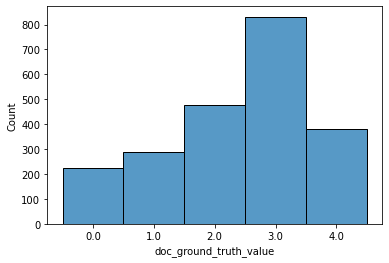

In [2]:
ground_truth = df["doc_ground_truth_value"].astype("string").sort_values()
sns.histplot(data=ground_truth, bins=5)

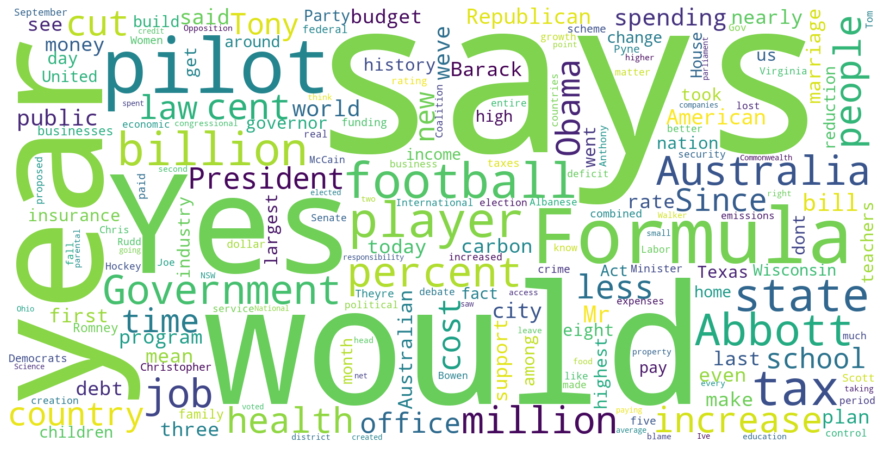

In [3]:
# word cloud overview
wc = WordCloud(collocations=False, background_color="white", width=1600, height=800, stopwords=STOP_WORDS).generate(" ".join(df["doc_statement"]))
plt.figure(figsize=(16, 8))
plt.imshow(wc, interpolation="bilinear")
plt.axis("off")
plt.show()

In [74]:
# text preprocessing
def clean_text(t):
    text = re.sub("([^\s\w]|_)+", "", t)
    text = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", text)
    text = text.lower()
    text = text.split(" ")

    for word in list(text):
        tagged = nltk.pos_tag([word])
        if word in STOP_WORDS or len(word) <= 2:
            text.remove(word)
        elif tagged[0][1] not in ["NN", "NNS", "JJ", "JJR", "JJS", "RB", "RBR", "RBS", "VB", "VBG", "VBD", "VBN", "VBP", "VBZ"]:
            text.remove(word)
    
    text = map(WordNetLemmatizer().lemmatize, text)

    return list(text)

corpus = df["doc_statement"]
corpus = corpus.dropna(how="any")
corpus = corpus.apply(clean_text)
df["doc_statement_tokens"] = corpus
corpus.head()

<>:3: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \d
<>:3: DeprecationWarning: invalid escape sequence \s
<>:4: DeprecationWarning: invalid escape sequence \d
/tmp/ipykernel_1506/3207209314.py:3: DeprecationWarning: invalid escape sequence \s
  text = re.sub("([^\s\w]|_)+", "", t)
/tmp/ipykernel_1506/3207209314.py:4: DeprecationWarning: invalid escape sequence \d
  text = re.sub("^\d+\s|\s\d+\s|\s\d+$", "", text)


0    [state, matter, state, constitution, provides,...
1    [abbott, seems, suffering, little, bit, amnesi...
2    [australia, country, given, rating, aaa, stabl...
3                                                [yes]
4    [fall, ofonlypercent, texas, high, school, gra...
Name: doc_statement, dtype: object

In [5]:
# word embedding
model = word2vec.Word2Vec(corpus, vector_size=100, window=20, workers=4, min_count=20)
print(len(model.wv.index_to_key))
print(model.wv.index_to_key)
model.wv["state"]

323
['say', 'would', 'tax', 'year', 'player', 'football', 'pilot', 'formula', 'yes', 'state', 'government', 'abbott', 'australia', 'country', 'job', 'health', 'increase', 'people', 'law', 'le', 'cut', 'cent', 'president', 'obama', 'tony', 'office', 'time', 'spending', 'new', 'cost', 'school', 'bill', 'mr', 'since', 'world', 'public', 'republican', 'city', 'business', 'said', 'three', 'debt', 'weve', 'barack', 'first', 'mean', 'program', 'carbon', 'rate', 'even', 'support', 'american', 'see', 'budget', 'money', 'australian', 'make', 'today', 'plan', 'marriage', 'governor', 'eight', 'last', 'took', 'woman', 'day', 'texas', 'insurance', 'went', 'nation', 'history', 'u', 'highest', 'industry', 'get', 'largest', 'month', 'christopher', 'five', 'among', 'change', 'pyne', 'high', 'scott', 'income', 'wisconsin', 'party', 'family', 'act', 'united', 'reduction', 'house', 'around', 'romney', 'dollar', 'funding', 'democrat', 'theyre', 'paid', 'scheme', 'combined', 'crime', 'minister', 'federal', '

array([-0.17743862, -0.15392084, -0.08726898, -0.08819737, -0.1102262 ,
       -0.47594973,  0.10685978,  0.5519811 , -0.24354726, -0.23985562,
       -0.1457787 , -0.26907474, -0.20109013, -0.09829359, -0.01000277,
       -0.29776672, -0.2295312 , -0.43534714, -0.04415013, -0.41012883,
        0.00093638,  0.01199109, -0.02462869, -0.1054927 , -0.15567748,
        0.28651989, -0.2169178 , -0.13369939, -0.38278127, -0.05977903,
        0.07039608,  0.3090924 , -0.05608274, -0.0535326 , -0.03441627,
        0.14631078,  0.03050127, -0.27621427, -0.32583493, -0.5396386 ,
       -0.07458336, -0.2957421 , -0.07381075, -0.09216084,  0.3209352 ,
        0.1677981 , -0.13252923, -0.12753758,  0.12364181,  0.00791886,
        0.04191202, -0.07761031,  0.27913773,  0.00745689,  0.03528092,
        0.03000655, -0.14489001, -0.18011777, -0.2966332 ,  0.3300475 ,
        0.0562924 ,  0.20089872,  0.09824591, -0.38585284, -0.49927786,
        0.20186664,  0.32275566,  0.31534812, -0.22588973,  0.52

In [6]:
# dimension reduction
tokens = []
labels = []

for word in model.wv.index_to_key:
    tokens.append(model.wv[word])
    labels.append(word)

tsne_model = TSNE(n_components=2, init="pca", n_iter=2500)
vectors_2d = tsne_model.fit_transform(tokens)

/home/jiqi/miniconda3/envs/pyvis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(
/home/jiqi/miniconda3/envs/pyvis/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(


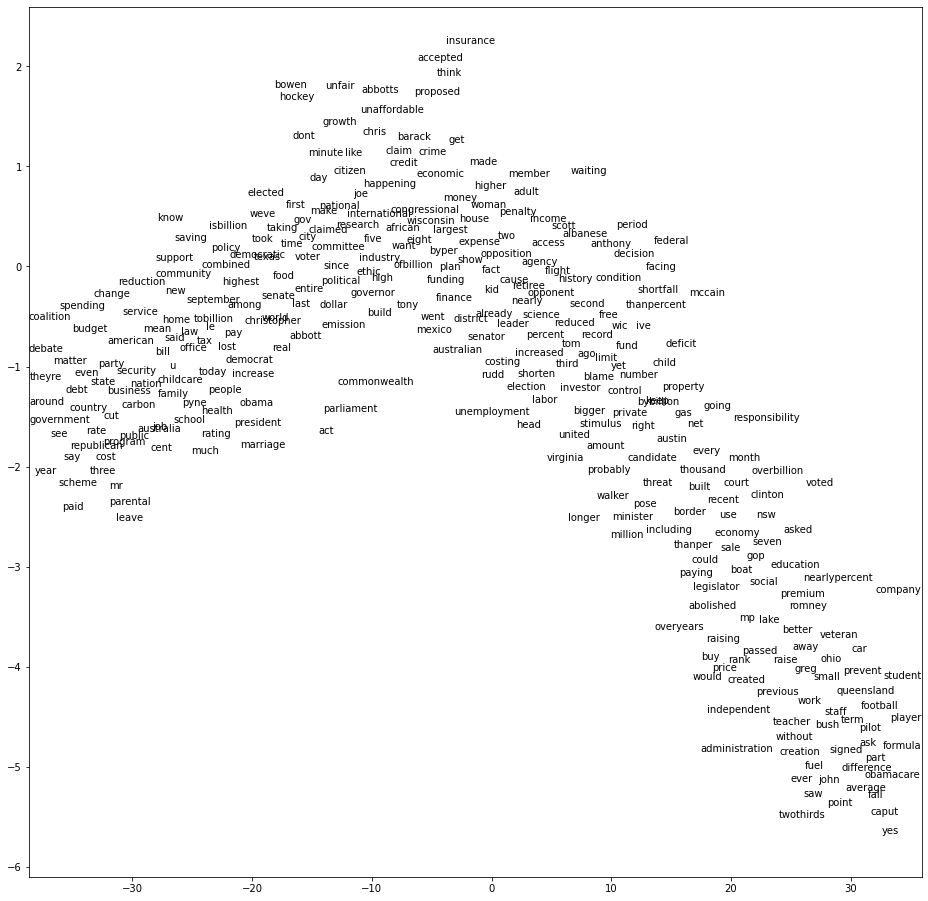

In [11]:
# plot semantic space
x = []
y = []
for v in vectors_2d:
    x.append(v[0])
    y.append(v[1])

plt.figure(figsize=(16, 16))
plt.plot(x, y, "bo", alpha=0)
texts = [plt.text(x[i], y[i], labels[i]) for i in range(len(x))]
adjust_text(texts)
plt.show()

In [39]:
id2word = Dictionary(corpus)
corpus_LDA = [id2word.doc2bow(t) for t in corpus]
lda_model = LdaModel(corpus=corpus_LDA, id2word=id2word, num_topics=20)
lda_model.print_topics()

[(0,
  '0.087*"thats" + 0.082*"gov" + 0.070*"today" + 0.067*"walker" + 0.059*"scott" + 0.047*"state" + 0.047*"spending" + 0.038*"education" + 0.034*"ask" + 0.026*"government"'),
 (1,
  '0.049*"created" + 0.049*"bigger" + 0.049*"program" + 0.042*"australia" + 0.041*"mr" + 0.036*"support" + 0.030*"would" + 0.030*"democrat" + 0.030*"law" + 0.029*"tarp"'),
 (2,
  '0.212*"cent" + 0.081*"fact" + 0.069*"get" + 0.043*"australia" + 0.041*"minister" + 0.020*"say" + 0.016*"country" + 0.016*"people" + 0.015*"australian" + 0.013*"would"'),
 (3,
  '0.031*"yes" + 0.016*"see" + 0.014*"president" + 0.012*"business" + 0.012*"percent" + 0.009*"make" + 0.009*"american" + 0.009*"small" + 0.009*"plan" + 0.009*"tax"'),
 (4,
  '0.034*"boat" + 0.026*"tax" + 0.022*"would" + 0.022*"say" + 0.022*"republican" + 0.021*"job" + 0.020*"bill" + 0.020*"business" + 0.019*"cut" + 0.019*"google"'),
 (5,
  '0.193*"yes" + 0.098*"net" + 0.048*"tax" + 0.040*"increase" + 0.039*"city" + 0.028*"tobillion" + 0.022*"year" + 0.020*"

The below code generates an interactive visualization for showing the LDA result.
Go to [this link](http://htmlpreview.github.io/?https://github.com/EyeofBeholder-NLeSC/play-around-sample-set/blob/main/html/ldavis.html) to see the visualization.

In [58]:
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus_LDA, id2word)
pyLDAvis.save_html(vis, "../html/ldavis.html")

/home/jiqi/miniconda3/envs/pyvis/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(


In [75]:
# devide reliable assessments based on user profile
reliable_assessments = df.loc[df["doc_ground_truth_value"] == df["doc_overall-truthfulness_value"] + 2]

print(reliable_assessments["q_0_political_views_answer"].unique())
print(reliable_assessments["q_0_consideration_answer"].unique())
print(reliable_assessments["q_0_southern_border_answer"].unique())

['Very liberal' 'Liberal' 'Moderate' 'Conservative' 'Very conservative']
['Independent' 'Republican' 'Democrat' 'Something else']
['Disagree' 'No opinion either way' 'Agree']


In [76]:
# clustering correlation matrix
def cluster_corr(corr_array, inplace=False):
    pairwise_distances = sch.distance.pdist(corr_array)
    linkage = sch.linkage(pairwise_distances, method='complete')
    cluster_distance_threshold = pairwise_distances.max()/2
    idx_to_cluster_array = sch.fcluster(linkage, cluster_distance_threshold, 
                                        criterion='distance')
    idx = np.argsort(idx_to_cluster_array)
    
    if not inplace:
        corr_array = corr_array.copy()
    
    if isinstance(corr_array, pd.DataFrame):
        return corr_array.iloc[idx, :].T.iloc[idx, :]
    return corr_array[idx, :][:, idx]

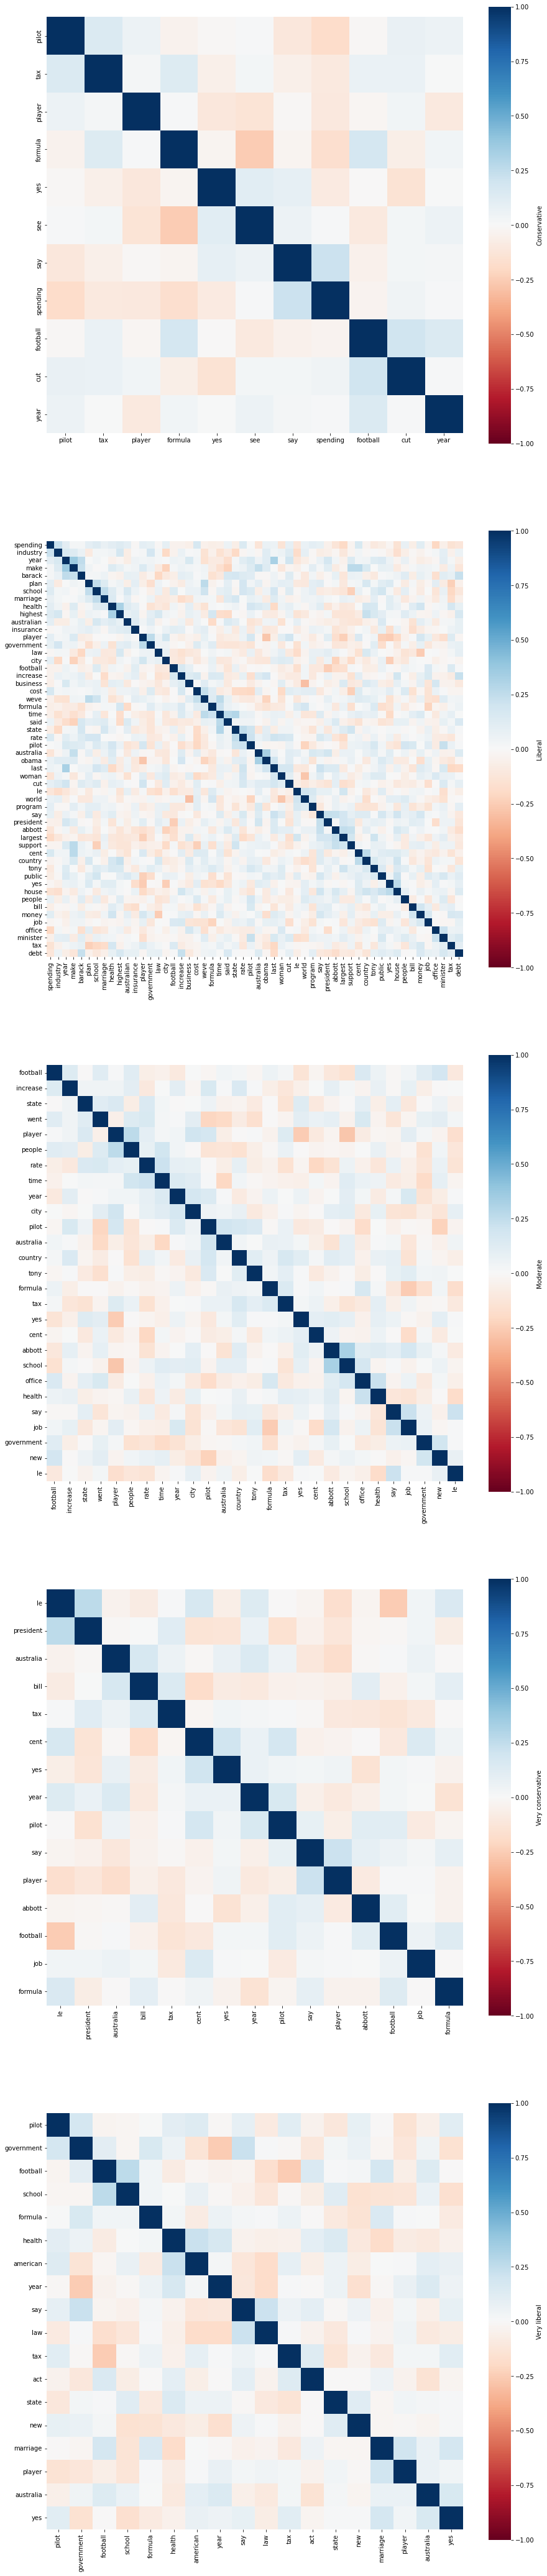

In [77]:
# split by the policical view question
groups = reliable_assessments.groupby(by="q_0_political_views_answer")
fig, axs = plt.subplots(5)
fig.set_size_inches(15, 75)
i = 0
for name, group in groups:
    group_corpus = group["doc_statement_tokens"]
    model = word2vec.Word2Vec(group_corpus, vector_size=100, window=20, workers=4, min_count=10)
    vectors = {}
    for token in model.wv.index_to_key:
        vectors[token] = model.wv[token] 
    vectors = pd.DataFrame(vectors, columns=model.wv.index_to_key)
    sns.heatmap(cluster_corr(vectors.corr()), cmap="RdBu", vmin=-1, vmax=1, square=True, cbar_kws={"label": name}, ax=axs[i])
    i += 1


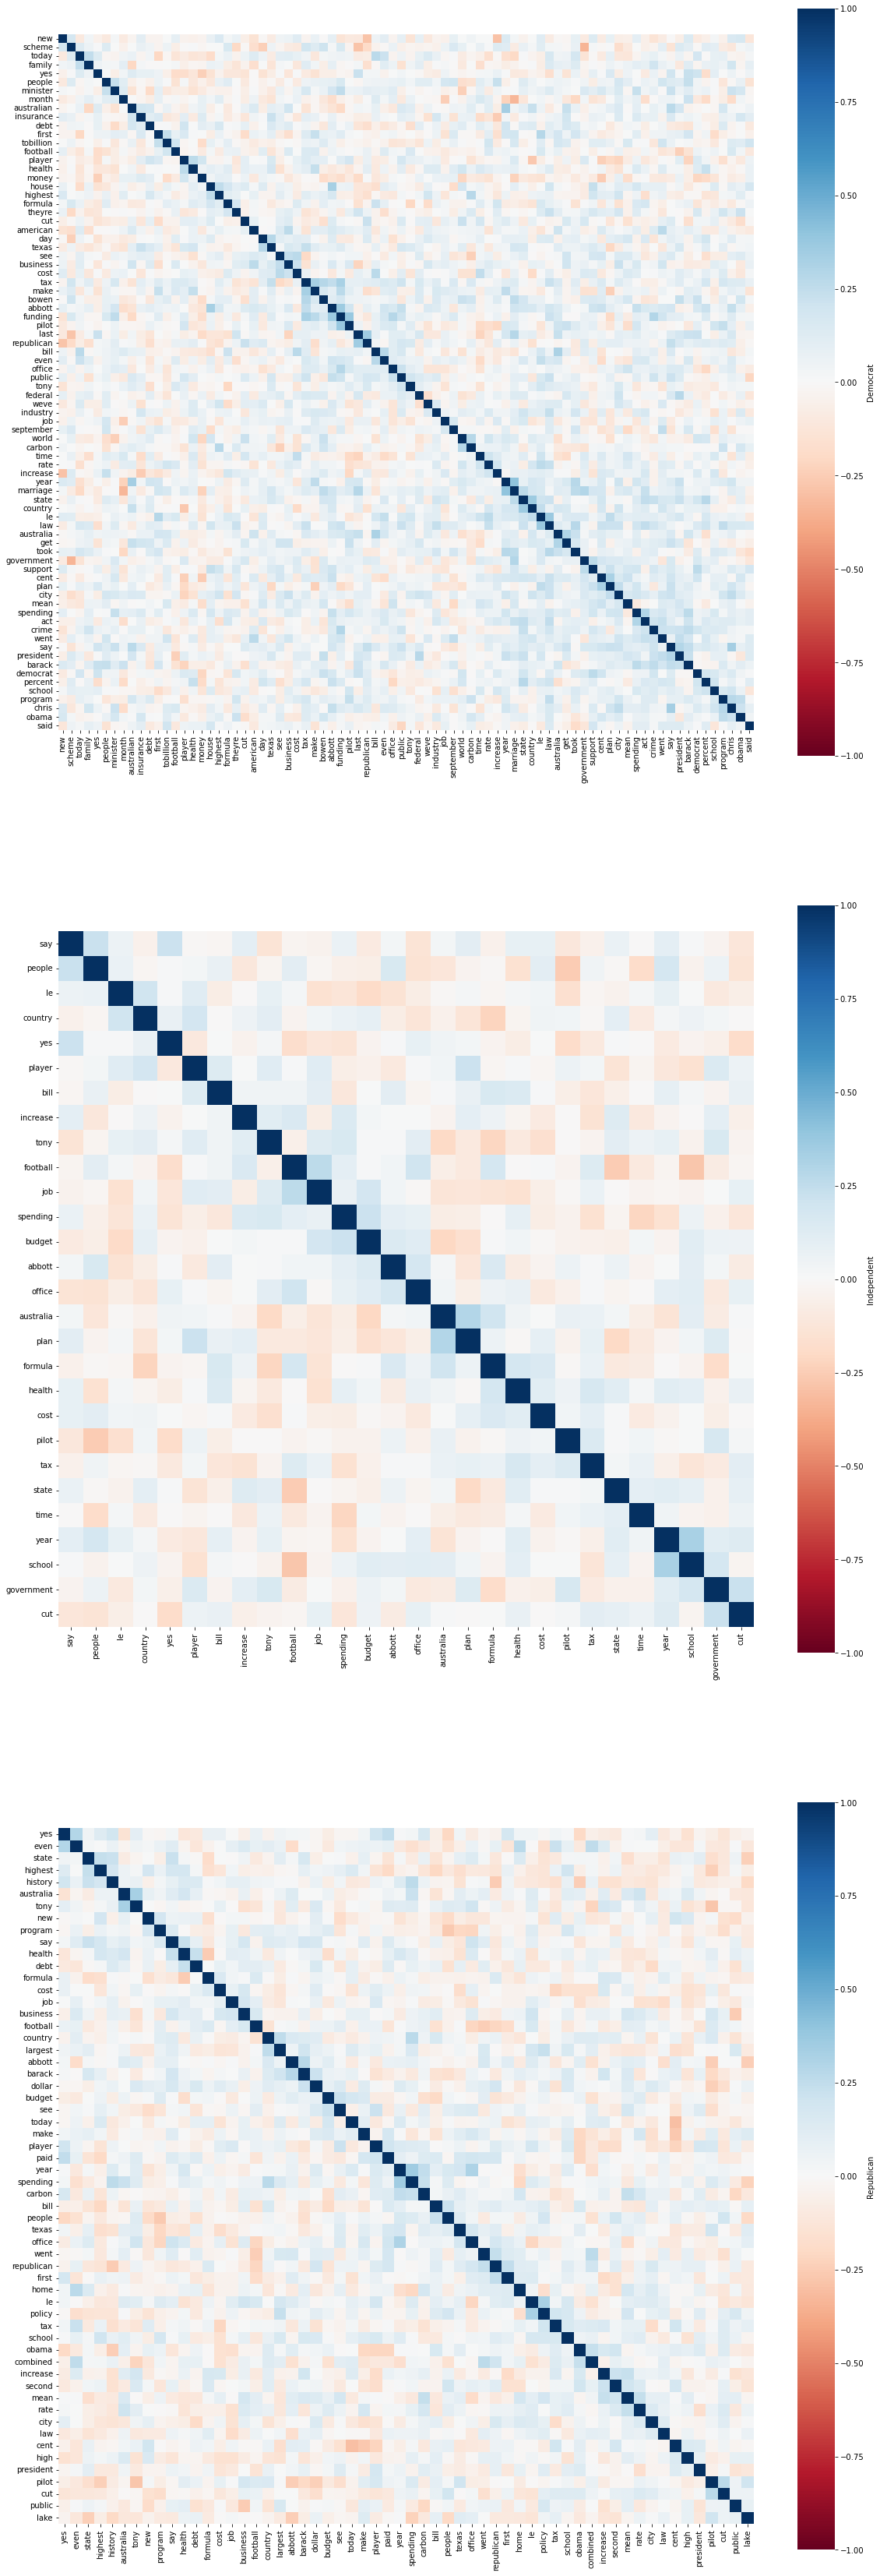

In [78]:
# split by the policical view question
groups = reliable_assessments.groupby(by="q_0_consideration_answer")
fig, axs = plt.subplots(3)
fig.set_size_inches(20, 60)
i = 0
for name, group in groups:
    group_corpus = group["doc_statement_tokens"]
    try:
        model = word2vec.Word2Vec(group_corpus, vector_size=100, window=20, workers=4, min_count=10)
    except RuntimeError: # no hashtags with frequency higher than 10
        continue
    vectors = {}
    for token in model.wv.index_to_key:
        vectors[token] = model.wv[token] 
    vectors = pd.DataFrame(vectors, columns=model.wv.index_to_key)
    sns.heatmap(cluster_corr(vectors.corr()), cmap="RdBu", vmin=-1, vmax=1, square=True, cbar_kws={"label": name}, ax=axs[i])
    i += 1

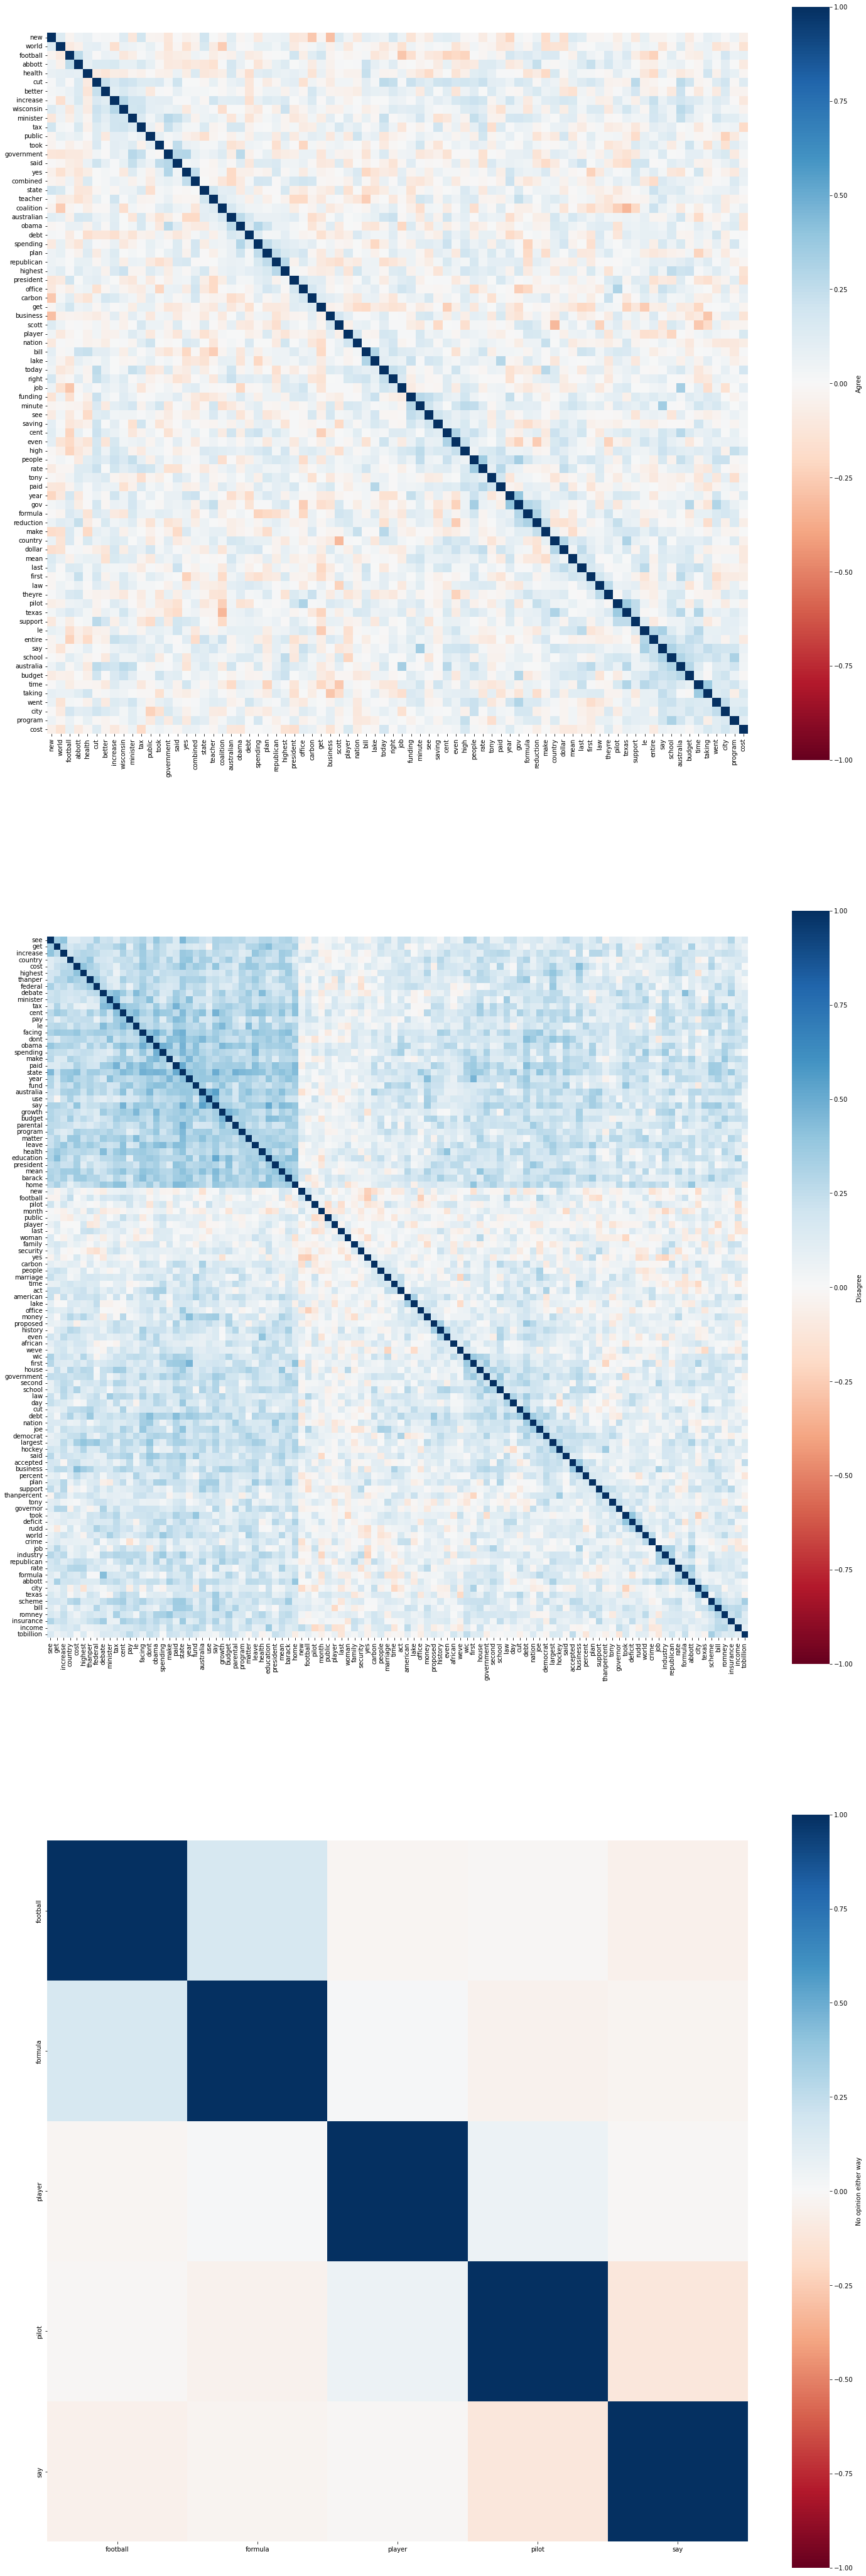

In [79]:
# split by the policical view question
groups = reliable_assessments.groupby(by="q_0_southern_border_answer")
fig, axs = plt.subplots(3)
fig.set_size_inches(25, 75)
i = 0
for name, group in groups:
    group_corpus = group["doc_statement_tokens"]
    model = word2vec.Word2Vec(group_corpus, vector_size=100, window=20, workers=4, min_count=10)
    vectors = {}
    for token in model.wv.index_to_key:
        vectors[token] = model.wv[token] 
    vectors = pd.DataFrame(vectors, columns=model.wv.index_to_key)
    sns.heatmap(cluster_corr(vectors.corr()), cmap="RdBu", vmin=-1, vmax=1, square=True, cbar_kws={"label": name}, ax=axs[i])
    i += 1